In [2]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
import random

sm.set_framework('tf.keras')
sm.framework()

from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.utils import to_categorical

from keras.utils.vis_utils import plot_model

from sklearn import metrics

import math
import pandas as pd

import seaborn as sns

import ast
import json

Segmentation Models: using `keras` framework.


In [3]:
def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [4]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip = True,
                      vertical_flip = True,
                      fill_mode = 'reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        target_size = (64, 64),
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        target_size = (64, 64),
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [5]:
seed = 24
batch_size = 16
n_classes = 8

In [6]:
# model_names = ['Unet-resnet50', 'Unet-resnet101', 'Unet-resnet152', 'Unet-densenet121', 'Unet-densenet169',
#                'Unet-vgg19', 'FPN-vgg16', 'Linknet-mobilenetv2', 'FPN-densenet121', 'Linknet-resnet50']

model_names = ['Unet-resnet101','Unet-densenet121', 'Unet-vgg19', 'FPN-densenet121', 'Linknet-resnet50']

# model_names = ['Unet-resnet50', 'Unet-resnet101']
models_path = '/home/shrayank_mistry/Modules/current_models/model_stats/'

In [7]:
models = []
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    print(md, bk)
    models.append(load_model(models_path + f'{md}_{bk}/model.hdf5', compile = False))

Unet resnet101
Unet densenet121
Unet vgg19
FPN densenet121
Linknet resnet50


In [8]:
models

In [9]:
test_img_path = '/home/shrayank_mistry/Modules/data/kaggle_data/test_images/'
test_msk_path = '/home/shrayank_mistry/Modules/data/kaggle_data/test_masks/'

# test_img_path = '/home/shrayank_mistry/Modules/data/kaggle_data/main_test_image/'
# test_msk_path = '/home/shrayank_mistry/Modules/data/kaggle_data/main_test_mask/'

test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)

In [10]:
image_cnt = len(os.listdir(test_img_path + 'test/'))
image_cnt

FileNotFoundError: [Errno 2] No such file or directory: '/home/shrayank_mistry/Modules/data/kaggle_data/test_images/test/'

### Storing IoU Comparison stats for Models

In [110]:
iou_storage = {}
itrs = image_cnt // batch_size
# itrs = 10
index = 0
# itrs

for model in models:
    test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)
    
    ious = []
    for i in range(itrs):
        test_image_batch, test_mask_batch = test_img_gen.__next__()


        test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
        test_pred_batch = model.predict(test_image_batch)
        test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

        IOU_keras = MeanIoU(num_classes = n_classes)
        IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax) 
        
        ious.append(IOU_keras.result().numpy())
    
    iou_storage[model_names[index]] = np.array(ious).tolist()
    index = index + 1

p = '/home/shrayank_mistry/Modules/current_models/'
with open(f'{p}ious_batchwise.txt', 'w') as f:
    f.write(json.dumps(iou_storage))


Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.


### Storing Pixel Comparison stats for models

In [111]:
itrs

1042

In [112]:
pxs_storage = {}
index = 0

for model in models:
    test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)
    pxs = []
    for i in range(itrs):
        test_image_batch, test_mask_batch = test_img_gen.__next__()

        test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
        test_pred_batch = model.predict(test_image_batch)
        test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

        for j in range(batch_size):
            correct = test_pred_batch_argmax[j] == test_mask_batch_argmax[j]
            pxs.append(float(correct.sum() / (correct.shape[0] * correct.shape[1])))
    
    pxs_storage[model_names[index]] = np.array(pxs).tolist()
    index = index + 1

p = '/home/shrayank_mistry/Modules/current_models/'
with open(f'{p}pxs_imagewise.txt', 'w') as f:
    f.write(json.dumps(pxs_storage))

Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.


### Confusion Matrix for One Batch

In [113]:
itrs = image_cnt // batch_size
itrs

1042

In [114]:
model_names

['Unet-resnet50',
 'Unet-resnet101',
 'Unet-resnet152',
 'Unet-densenet121',
 'Unet-densenet169',
 'Unet-vgg19',
 'FPN-vgg16',
 'Linknet-mobilenetv2',
 'FPN-densenet121',
 'Linknet-resnet50']

In [31]:
batch_size = 64
test_img_path = '/home/shrayank_mistry/Modules/project_4413/kaggle_data/test_images/'
test_msk_path = '/home/shrayank_mistry/Modules/project_4413/kaggle_data/test_masks/'

In [32]:
conf_storage = {}
index = 0

test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)
test_image_batch, test_mask_batch = test_img_gen.__next__()

for model in models:

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    cs = 8
    confusion_matrix = np.zeros((cs, cs), dtype = 'int')

    for x in range(batch_size):
        target = test_mask_batch_argmax[x]
        prediction = test_pred_batch_argmax[x]   

        r = target.shape[0]
        c = target.shape[1]

        for i in range(r):
            for j in range(c):
                target_pixel = target[i][j]
                predict_pixel = prediction[i][j]
                
                confusion_matrix[predict_pixel][target_pixel] += 1
        
    conf_storage[model_names[index]] = confusion_matrix.tolist()
    index = index + 1

p = '/home/shrayank_mistry/Modules/current_models/'
with open(f'{p}confusion_matrix.txt', 'w') as f:
    f.write(json.dumps(conf_storage))


Found 16677 images belonging to 1 classes.
Found 16677 images belonging to 1 classes.


### Confusion Matrix Visualization and Comparison

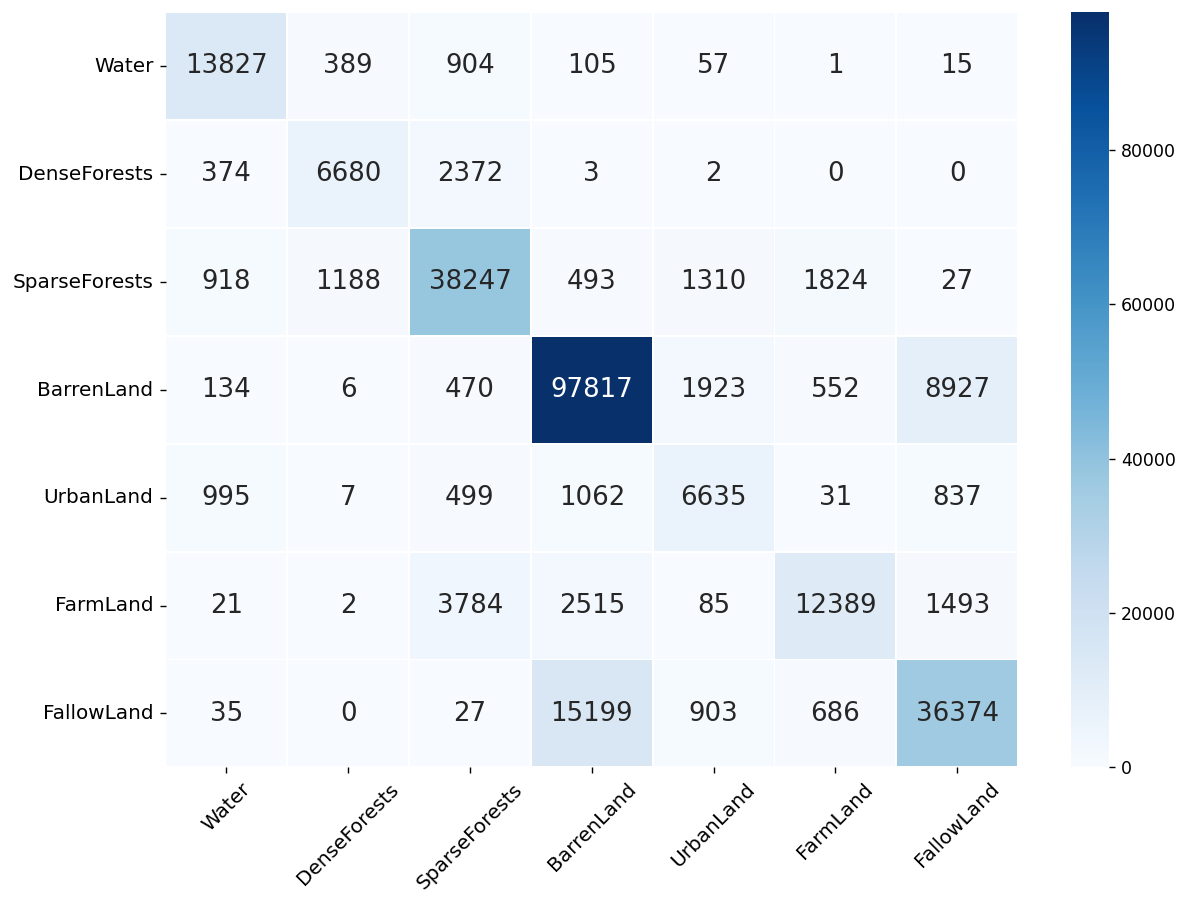

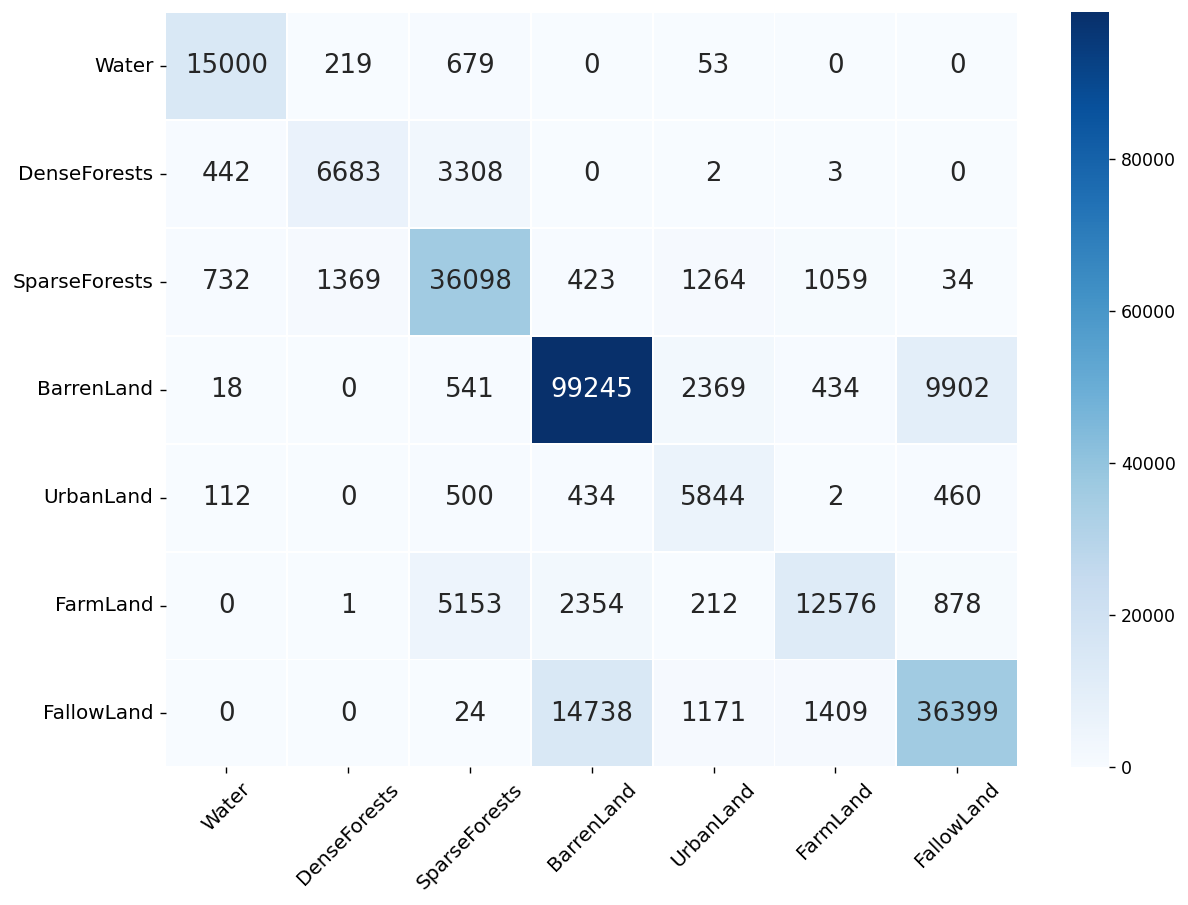

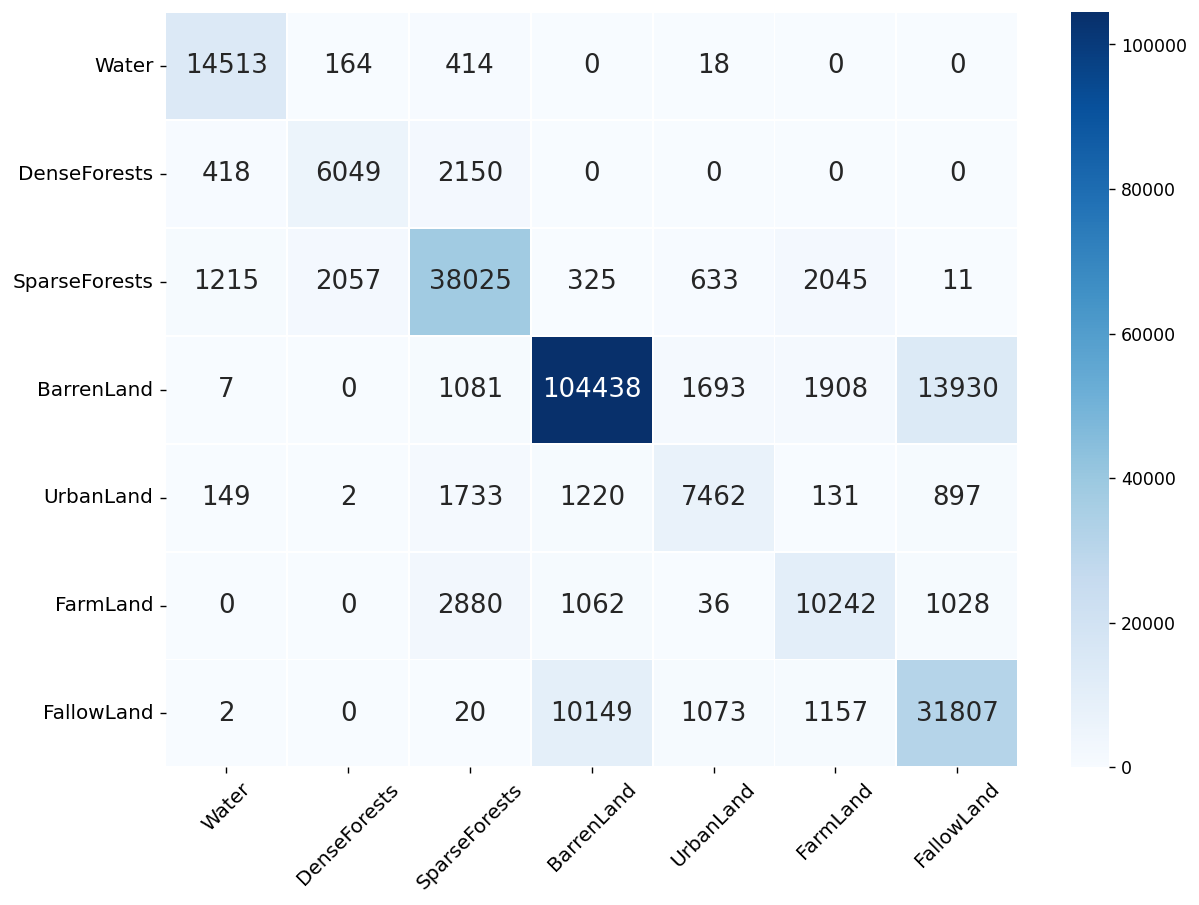

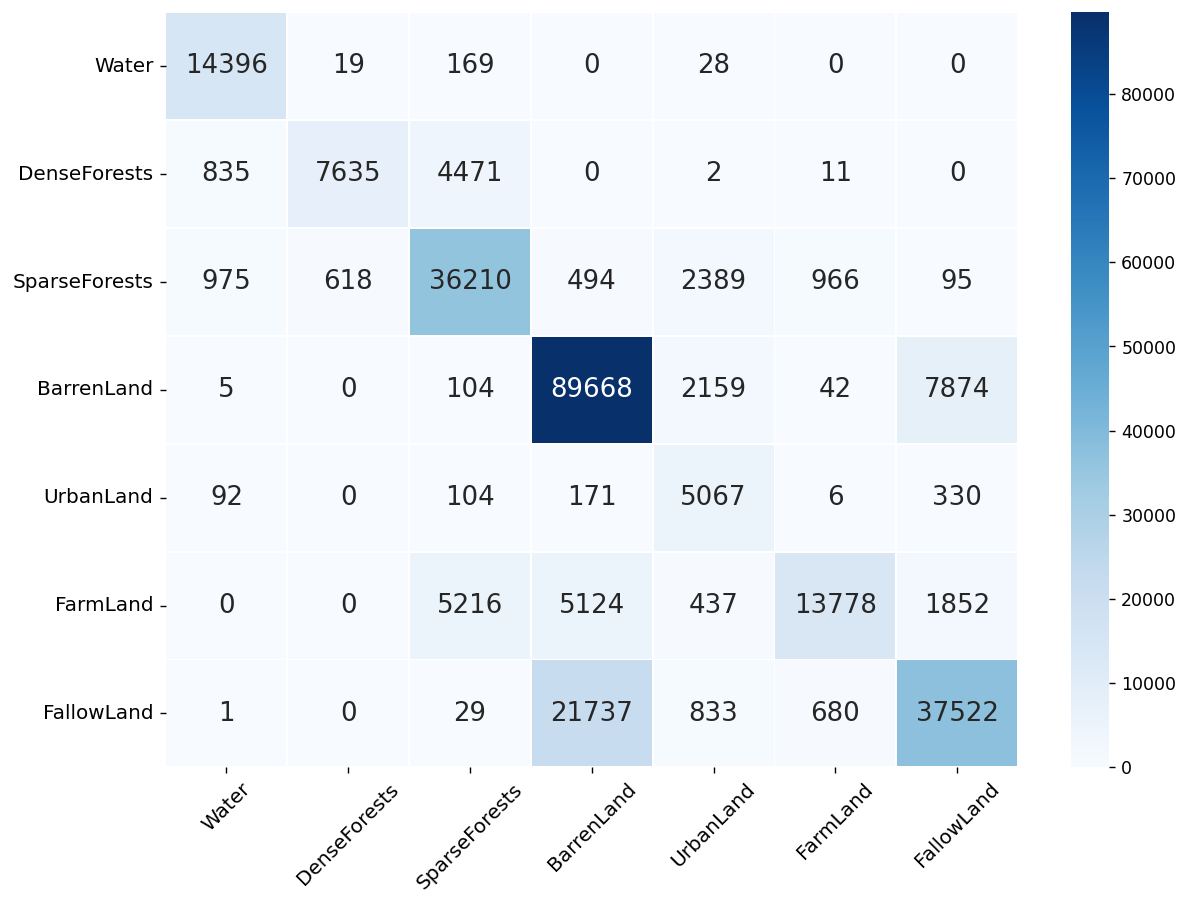

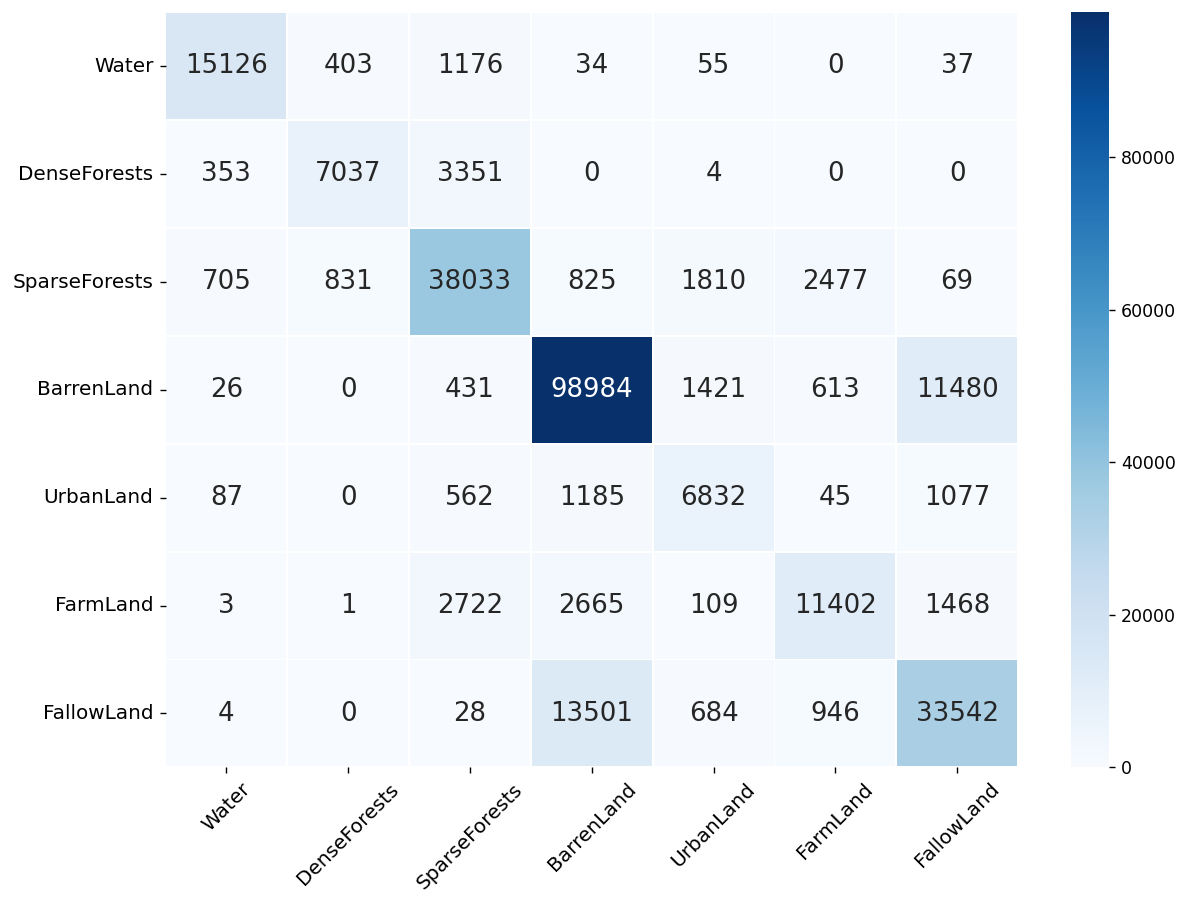

In [33]:
index = 0
p = '/home/shrayank_mistry/Modules/current_models/'
file = open(f'{p}confusion_matrix.txt', 'r')
contents = file.read()

dt = ast.literal_eval(contents)

for model in models:
#     confusion_matrix = dt[model_names[index]]
    confusion_matrix = np.array(dt[model_names[index]])

#     classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
    classes = ['Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']

    plt.figure(figsize = (11, 8), dpi = 125)

    cm_df = pd.DataFrame(data = confusion_matrix[1:,1:], index = classes, columns = classes)
    sns.heatmap(data = cm_df, annot = True, linewidths = 0.5, 
        #     cmap = 'viridis_r',
            cmap = 'Blues', 
            fmt = 'd', annot_kws={"fontsize":15});

    plt.xticks(rotation = 45, fontsize = 11.5);
    plt.yticks(fontsize = 11.5)
    plt.savefig(f'{p}Confusion matrics/{model_names[index]}_confusion.jpg', format = 'jpg', dpi = 600)

    index = index + 1


## Metrics Comparison for Models

$$Presision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

$$Overall Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

$$F1-Score = \frac{2 * TP}{2 * TP + FP + FN}$$

$$MCC = \frac{(TP * TN) - (FP * FN)}{\sqrt{(TP + FP) * (TP + FN) * (TN + FP) * (TN + FN)}}$$

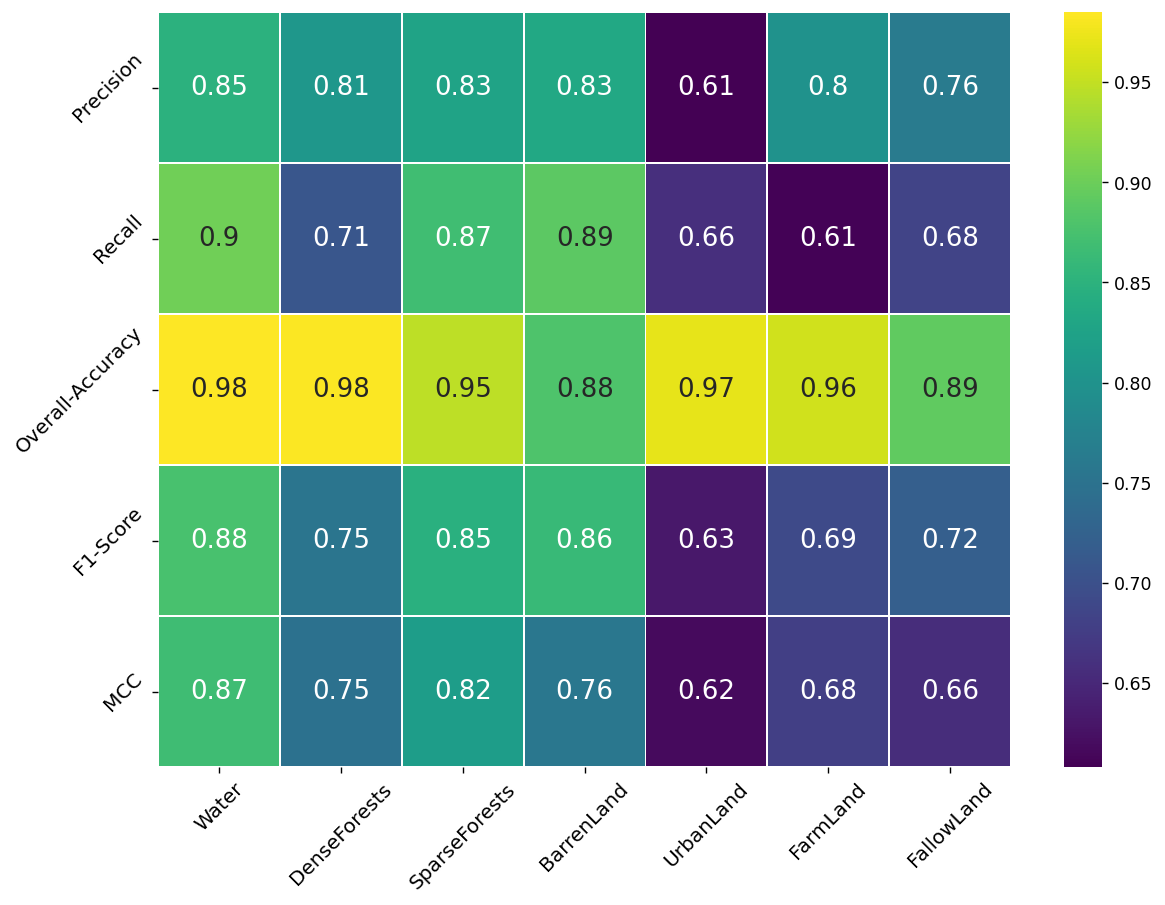

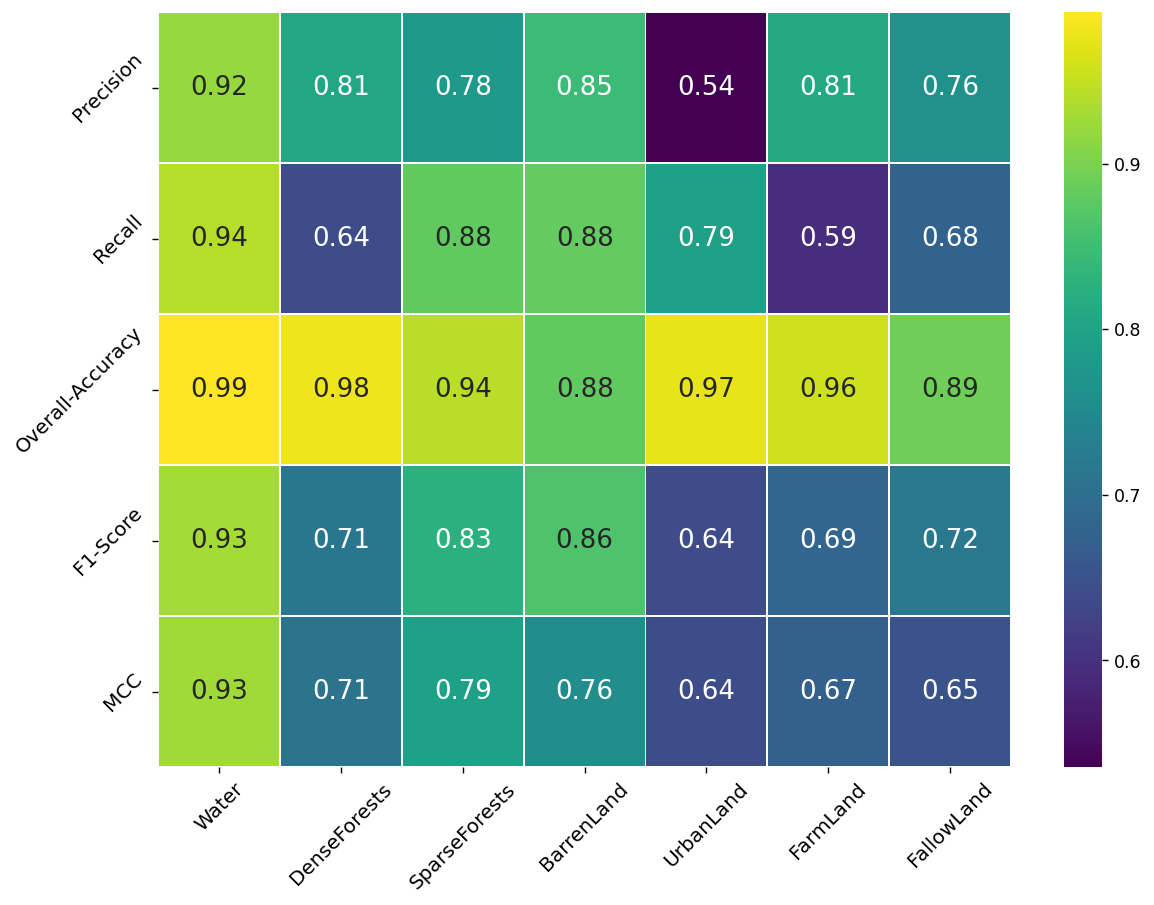

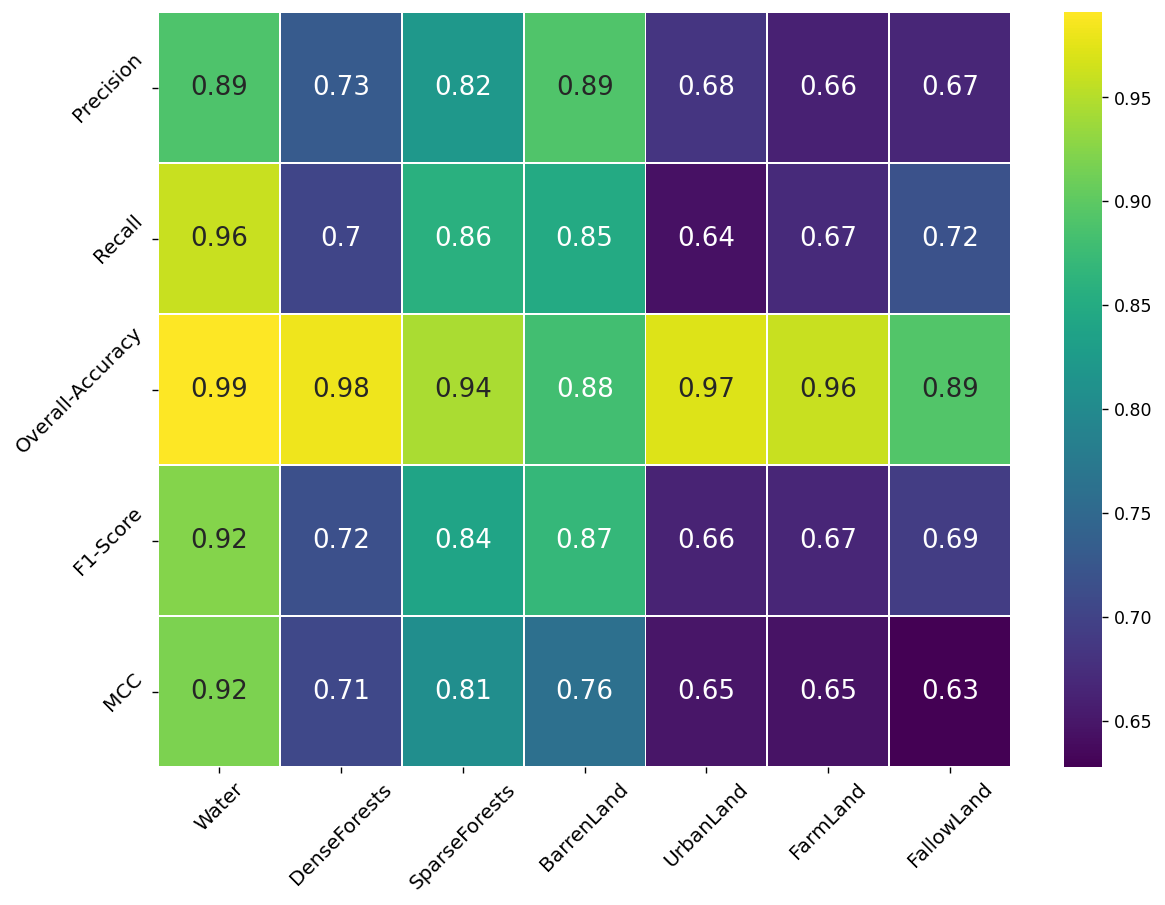

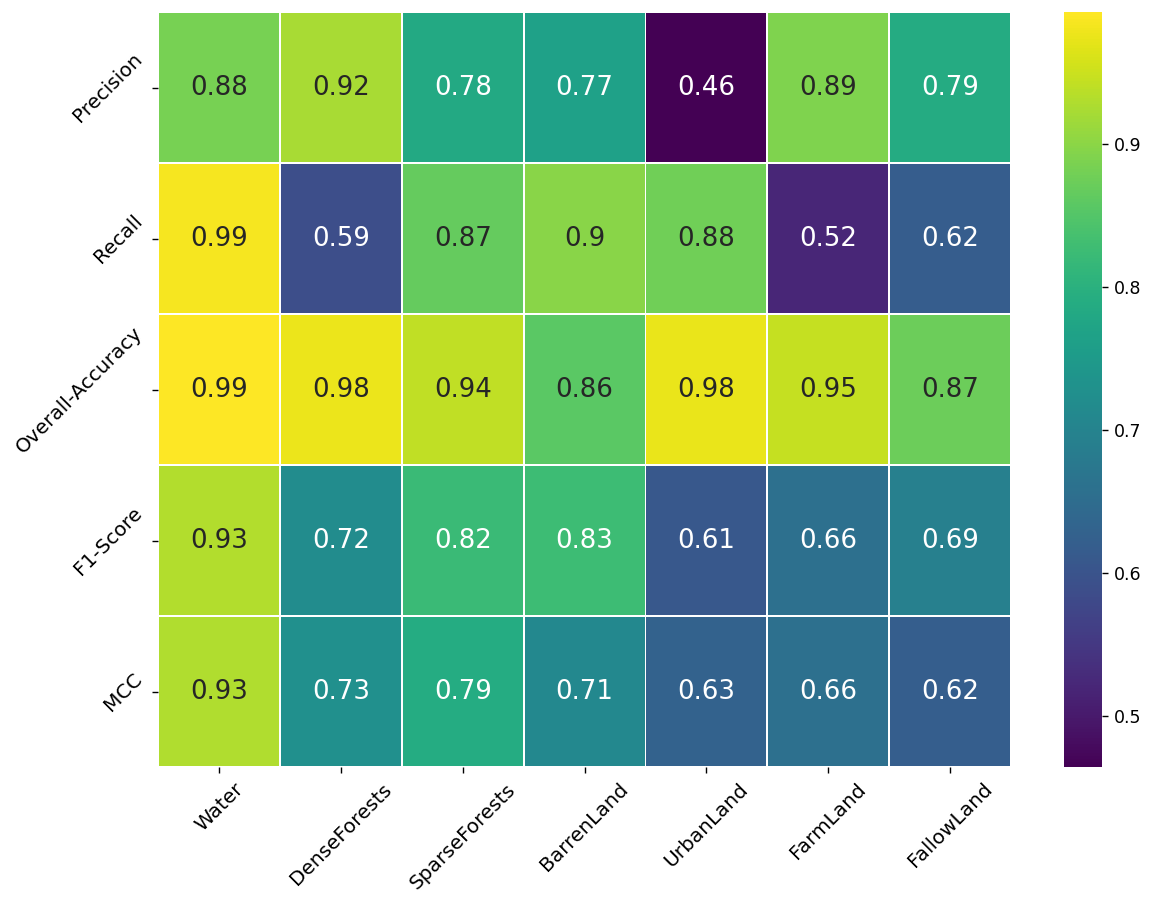

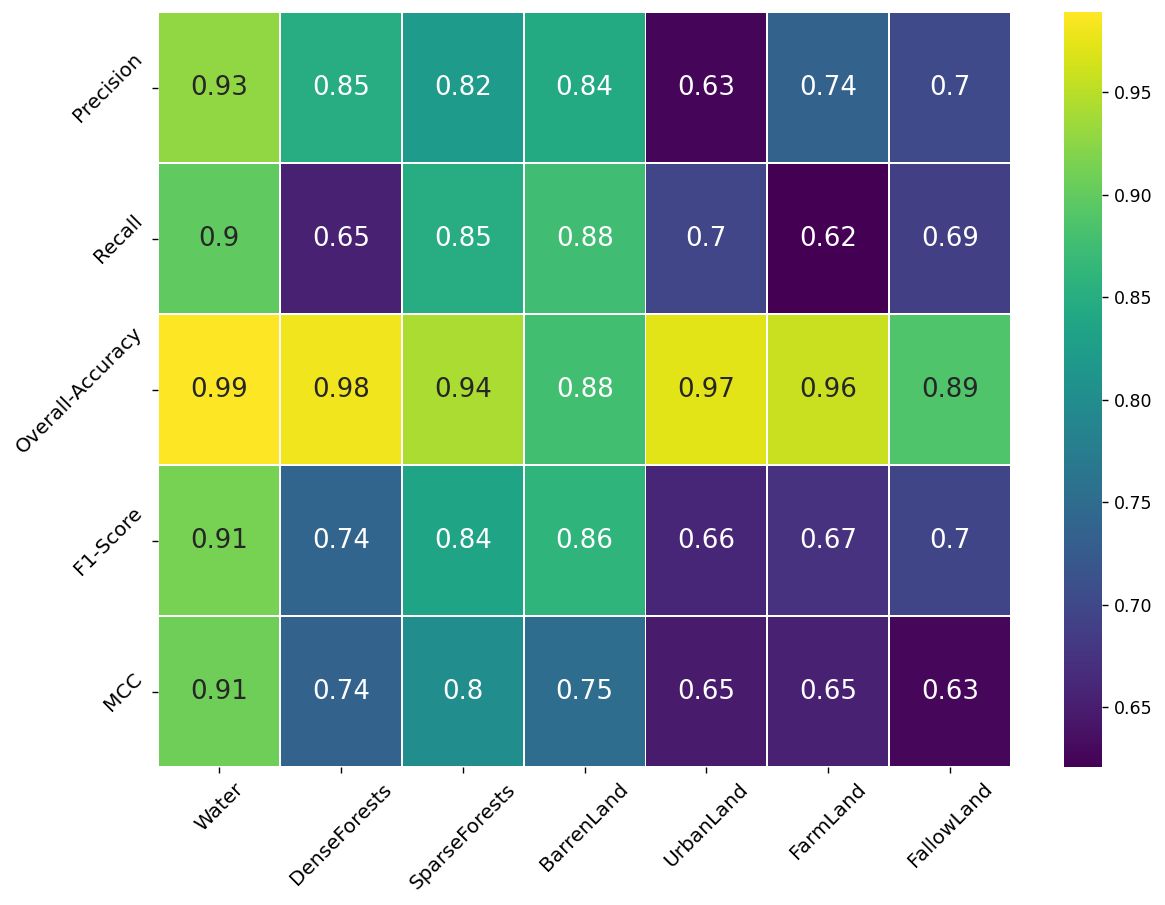

In [34]:
index = 0
path = '/home/shrayank_mistry/Modules/current_models/'
file = open(f'{path}confusion_matrix.txt', 'r')
contents = file.read()

dt = ast.literal_eval(contents)

for model in models:
    classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
    headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']

    confusion_matrix = dt[model_names[index]]

    metrics = {}
    for c in range(1, len(classes)):
        tp, fn, fp, tn = 0, 0, 0, 0

        p, r, o, f, m = 0, 0, 0, 0, 0

        # True Positive
        tp = confusion_matrix[c][c]
        
        # False Negative
        for i in range(len(classes)):
            if i == c: continue
            fn += confusion_matrix[c][i]
        
        # False Positive
        for i in range(len(classes)):
            if i == c: continue
            fp += confusion_matrix[i][c]
        
        # True Negative
        for i in range(len(classes)):
            if i == c: continue
            for j in range(len(classes)):
                if j == c: continue

                tn += confusion_matrix[i][j]
        
        # print(f'Class {c}, Metrics = [TP {tp}, FN {fn}, FP {fp}, TN {tn}]')

        p = tp / (tp + fp)
        r = tp / (tp + fn)
        o = (tp + tn) / (tp + fp + tn + fn)
        f = (2 * tp) / ((2 * tp) + (fp + fn))
        m = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

        metrics[classes[c]] = [p, r, o, f, m]
    
    df = pd.DataFrame(metrics, index = headers)
    plt.figure(figsize = (11, 8), dpi = 125)
    sns.heatmap(data = df, annot = True, linewidths = 0.5, cmap = 'viridis', annot_kws={"fontsize":15});

    # plt.savefig()
    plt.yticks(rotation = 45, fontsize = 11.5);
    plt.xticks(rotation = 45, fontsize = 11.5);
    # plt.legend(fontsize = 11.5);
    plt.savefig(f'{path}/Metrics/{model_names[index]}_metrics.jpg', format = 'jpg', dpi = 600)

    index = index + 1
        

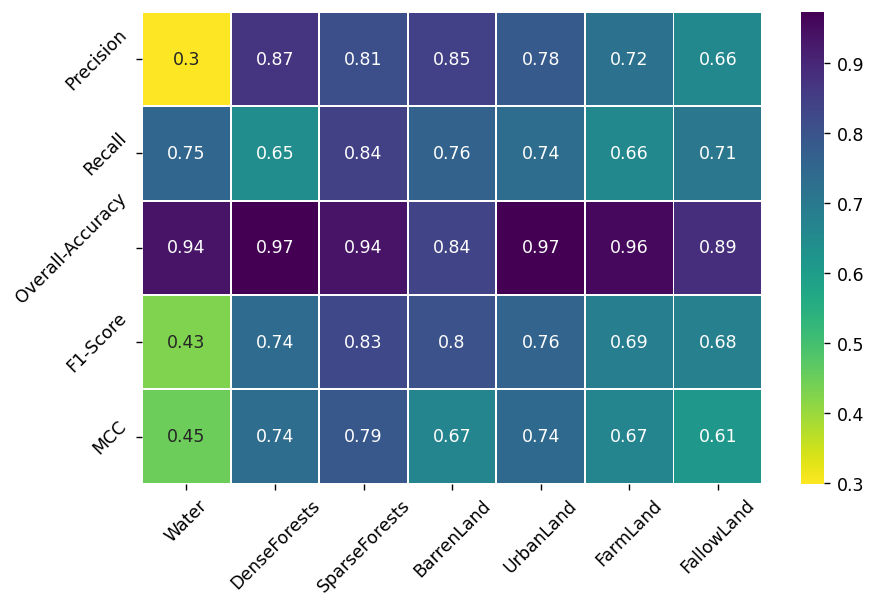

In [384]:
# df = pd.DataFrame(metrics, index = headers)
# plt.figure(figsize = (8, 5), dpi = 125)
# sns.heatmap(data = df, annot = True, linewidths = 0.5, 
#         cmap = 'viridis_r');

# plt.yticks(rotation = 45);
# plt.xticks(rotation = 45);

In [118]:
import matplotlib.colors
# 7 colors
# [Water, DenseForest, SparseForest, BarrenLand, UrbanLand, FarmLand, FallowLand]
# [#0033cc, #006600, #33cc33, #663300, #5200cc, #ffcc00, #e68a00]

cp = matplotlib.colors.LinearSegmentedColormap.from_list('', ['#0033cc', '#006600', '#33cc33', '#663300', '#5200cc', '#ffcc00', '#e68a00'])

In [23]:
batch_size = 256
test_img_gen = trainGenerator(test_img_path, test_msk_path, num_class = n_classes)

### Test Image Storing

In [ ]:
test_image_batch, test_mask_batch = test_img_gen.__next__()
index = 0
for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    store_path = f'/home/shrayank_mistry/Modules/current_models/model_stats/{md}_{bk}/'
    # os.mkdir(store_path + 'test_output/')

    test_mask_batch_argmax = np.argmax(test_mask_batch, axis = 3) 
    test_pred_batch = models[index].predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis = 3)

    for i in range(batch_size):

        # path = store_path + 'test_output/'
        path = store_path
        # os.mkdir(path)
        plt.figure(figsize = (12, 10))
        plt.subplot(231)
        plt.title('Testing Image')
        plt.imshow(test_image_batch[i])
        # plt.savefig(f'{path}/image.jpg')

        plt.subplot(232)
        plt.title('Testing Label')
        plt.imshow(test_mask_batch_argmax[i], cmap = cp)
        # plt.savefig(f'{path}/mask.jpg')

        plt.subplot(233)
        plt.title('Prediction on test image')
        plt.imshow(test_pred_batch_argmax[i], cmap = cp)
        # plt.savefig(f'{path}/output_{i + 1}.jpg')
        # fig.savefig('myimage.svg', format='svg', dpi=1200)
        plt.savefig(f'{path}/output_{i + 1}.jpg', format = 'jpg', dpi = 600)
    
    index = index + 1

### Model comparison on metrics

In [11]:
index = 0
path = '/home/shrayank_mistry/Modules/current_models/'
file = open(f'{path}confusion_matrix.txt', 'r')
contents = file.read()

dt = ast.literal_eval(contents)
model_data = []

for model in models:
    classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
    headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']

    confusion_matrix = dt[model_names[index]]

    metrics = {}
    for c in range(1, len(classes)):
        tp, fn, fp, tn = 0, 0, 0, 0

        p, r, o, f, m = 0, 0, 0, 0, 0

        # True Positive
        tp = confusion_matrix[c][c]
        
        # False Negative
        for i in range(len(classes)):
            if i == c: continue
            fn += confusion_matrix[c][i]
        
        # False Positive
        for i in range(len(classes)):
            if i == c: continue
            fp += confusion_matrix[i][c]
        
        # True Negative
        for i in range(len(classes)):
            if i == c: continue
            for j in range(len(classes)):
                if j == c: continue

                tn += confusion_matrix[i][j]
        
        # print(f'Class {c}, Metrics = [TP {tp}, FN {fn}, FP {fp}, TN {tn}]')

        p = tp / (tp + fp)
        r = tp / (tp + fn)
        o = (tp + tn) / (tp + fp + tn + fn)
        f = (2 * tp) / ((2 * tp) + (fp + fn))
        m = ((tp * tn) - (fp * fn)) / (math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))

        metrics[classes[c]] = [p, r, o, f, m]
    model_data.append(metrics)
    index = index + 1



classes = ['Unclassified', 'Water', 'DenseForests', 'SparseForests', 'BarrenLand', 'UrbanLand', 'FarmLand', 'FallowLand']
headers = ['Precision', 'Recall', 'Overall-Accuracy', 'F1-Score', 'MCC']


cmp_dict_water = {}   # Water Class
cmp_dict_dforest = {} # DenseForest
cmp_dict_sforest = {} # SparseForest
cmp_dict_barren = {}  # BarrenLand
cmp_dict_urban = {}   # UrbanLand
cmp_dict_farms = {}   # FarmLand
cmp_dict_fallow = {}  # FallowLand
 
index = 0
for mn in model_names:
    cmp_dict_water[mn] = model_data[index]['Water']
    cmp_dict_dforest[mn] = model_data[index]['DenseForests']
    cmp_dict_sforest[mn] = model_data[index]['SparseForests']
    cmp_dict_barren[mn] = model_data[index]['BarrenLand']
    cmp_dict_urban[mn] = model_data[index]['UrbanLand']
    cmp_dict_farms[mn] = model_data[index]['FarmLand']
    cmp_dict_fallow[mn] = model_data[index]['FallowLand']

    index = index + 1


index = 0

### Water Class Comparison

In [14]:
pd.set_option("display.precision", 4)
water_df = pd.DataFrame(cmp_dict_water, index = headers)
water_df

water_df = water_df.T
print(water_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.9596 &  0.9398 &            0.9921 &    0.9496 &  0.9454 \\
Unet-densenet121 &     0.9744 &  0.9318 &            0.9925 &    0.9526 &  0.9488 \\
Unet-vgg19       &     0.9225 &  0.9690 &            0.9917 &    0.9452 &  0.9410 \\
FPN-densenet121  &     0.9101 &  0.9935 &            0.9926 &    0.9500 &  0.9471 \\
Linknet-resnet50 &     0.9616 &  0.9302 &            0.9914 &    0.9456 &  0.9411 \\
\bottomrule
\end{tabular}



### DenseForest Class Comparison                                    

In [17]:
dforest_df = pd.DataFrame(cmp_dict_dforest, index = headers)
dforest_df  

dforest_df = dforest_df .T
print(dforest_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.8526 &  0.7011 &            0.9779 &    0.7695 &  0.7620 \\
Unet-densenet121 &     0.8523 &  0.7090 &            0.9785 &    0.7741 &  0.7664 \\
Unet-vgg19       &     0.7401 &  0.7375 &            0.9774 &    0.7388 &  0.7270 \\
FPN-densenet121  &     0.9284 &  0.6624 &            0.9764 &    0.7732 &  0.7732 \\
Linknet-resnet50 &     0.8801 &  0.6958 &            0.9782 &    0.7772 &  0.7717 \\
\bottomrule
\end{tabular}



### SparseForest Class Comparison                                       

In [18]:
sforest_df = pd.DataFrame(cmp_dict_sforest, index = headers)
sforest_df  

sforest_df = sforest_df .T
print(sforest_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.8106 &  0.8420 &            0.9373 &    0.8260 &  0.7880 \\
Unet-densenet121 &     0.7850 &  0.8643 &            0.9379 &    0.8228 &  0.7866 \\
Unet-vgg19       &     0.8415 &  0.8355 &            0.9405 &    0.8385 &  0.8020 \\
FPN-densenet121  &     0.7766 &  0.8646 &            0.9367 &    0.8182 &  0.7817 \\
Linknet-resnet50 &     0.8276 &  0.8241 &            0.9359 &    0.8259 &  0.7866 \\
\bottomrule
\end{tabular}



### BarrenLand Class Comparison             

In [19]:
barren_df = pd.DataFrame(cmp_dict_barren, index = headers)
barren_df       

barren_df = barren_df.T
print(barren_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.8322 &  0.8579 &            0.8800 &    0.8449 &  0.7473 \\
Unet-densenet121 &     0.8228 &  0.8472 &            0.8721 &    0.8349 &  0.7308 \\
Unet-vgg19       &     0.8799 &  0.8148 &            0.8743 &    0.8461 &  0.7416 \\
FPN-densenet121  &     0.7735 &  0.8680 &            0.8648 &    0.8180 &  0.7140 \\
Linknet-resnet50 &     0.8425 &  0.8470 &            0.8784 &    0.8448 &  0.7448 \\
\bottomrule
\end{tabular}



### UrbanLand Class             

In [20]:
urban_df = pd.DataFrame(cmp_dict_urban, index = headers)
urban_df

urban_df = urban_df.T
print(urban_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.6844 &  0.7862 &            0.9709 &    0.7318 &  0.7184 \\
Unet-densenet121 &     0.6105 &  0.8320 &            0.9702 &    0.7043 &  0.6981 \\
Unet-vgg19       &     0.7238 &  0.6914 &            0.9652 &    0.7072 &  0.6890 \\
FPN-densenet121  &     0.6024 &  0.9063 &            0.9733 &    0.7237 &  0.7267 \\
Linknet-resnet50 &     0.7238 &  0.7523 &            0.9701 &    0.7377 &  0.7221 \\
\bottomrule
\end{tabular}



### FarmLand Class

In [21]:
farms_df = pd.DataFrame(cmp_dict_farms, index = headers)
farms_df

farms_df = farms_df.T
print(farms_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.7447 &  0.6272 &            0.9575 &    0.6809 &  0.6611 \\
Unet-densenet121 &     0.7630 &  0.6110 &            0.9560 &    0.6786 &  0.6600 \\
Unet-vgg19       &     0.6623 &  0.7115 &            0.9631 &    0.6860 &  0.6669 \\
FPN-densenet121  &     0.8527 &  0.5505 &            0.9486 &    0.6690 &  0.6607 \\
Linknet-resnet50 &     0.6683 &  0.6554 &            0.9584 &    0.6618 &  0.6397 \\
\bottomrule
\end{tabular}



### FallowLand Class

In [22]:
fallow_df = pd.DataFrame(cmp_dict_fallow, index = headers)
fallow_df

fallow_df = fallow_df.T
print(fallow_df.to_latex(index = True))

\begin{tabular}{lrrrrr}
\toprule
{} &  Precision &  Recall &  Overall-Accuracy &  F1-Score &     MCC \\
\midrule
Unet-resnet101   &     0.7032 &  0.6892 &            0.8870 &    0.6961 &  0.6268 \\
Unet-densenet121 &     0.7159 &  0.6581 &            0.8793 &    0.6858 &  0.6121 \\
Unet-vgg19       &     0.6069 &  0.7142 &            0.8830 &    0.6562 &  0.5891 \\
FPN-densenet121  &     0.7667 &  0.6395 &            0.8775 &    0.6974 &  0.6254 \\
Linknet-resnet50 &     0.6540 &  0.6987 &            0.8844 &    0.6756 &  0.6059 \\
\bottomrule
\end{tabular}



### Training Loss Model Comparison

In [129]:
models_path = '/home/shrayank_mistry/Modules/current_models/model_stats/'

mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['train_loss'])


In [130]:
mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

In [131]:
path = '/home/shrayank_mistry/Modules/current_models/'

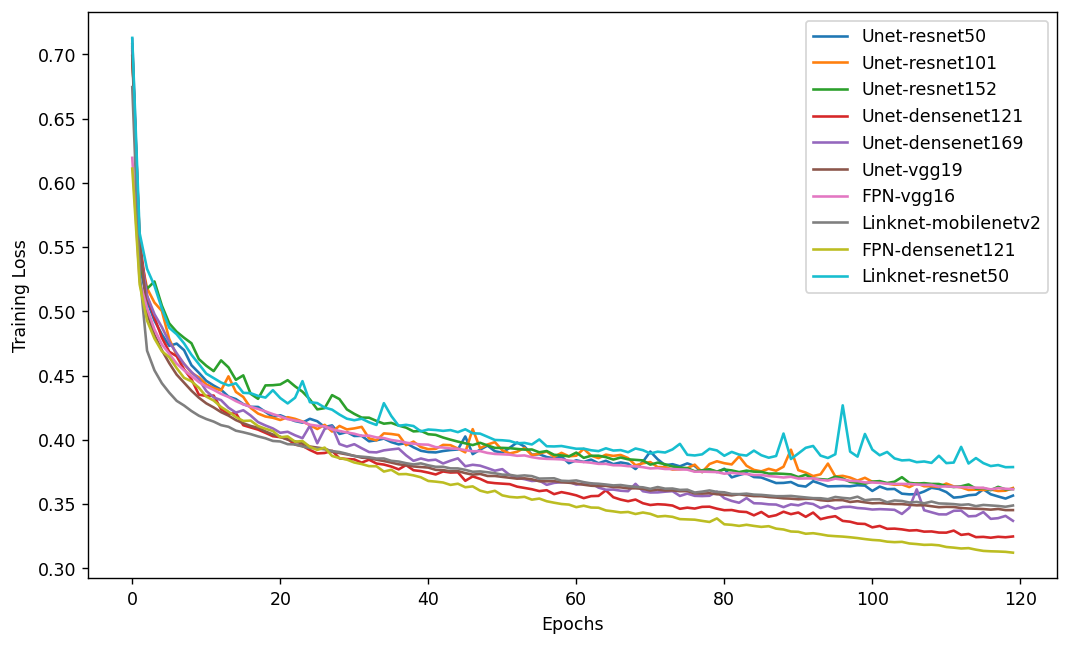

In [132]:
plt.figure(figsize = (10, 6), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Training Loss');

# plt.savefig(f'{path}/output_{i + 1}.jpg', format = 'jpg', dpi = 1200)
plt.savefig(f'{path}/train_loss.jpg', format = 'jpg', dpi = 1200)

### Training IoU Comparison

In [133]:
mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['iou'])

In [134]:
mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

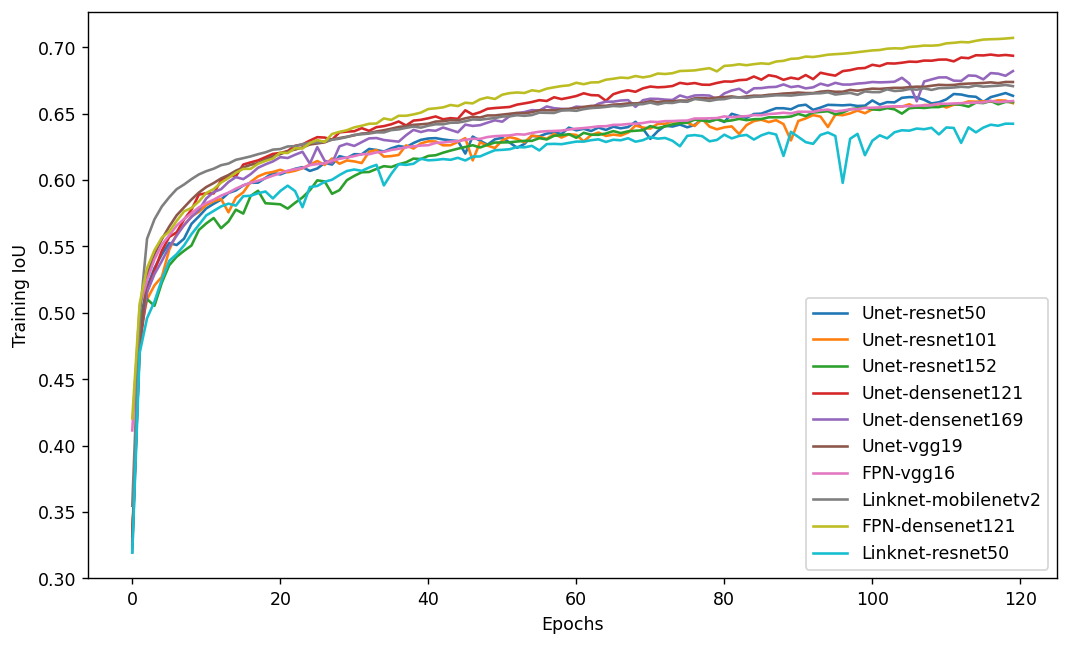

In [135]:
plt.figure(figsize = (10, 6), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Training IoU');
plt.savefig(f'{path}/train_iou.jpg', format = 'jpg', dpi = 600)

### Validation Loss Comparison

In [136]:
mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['val_loss'])

mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

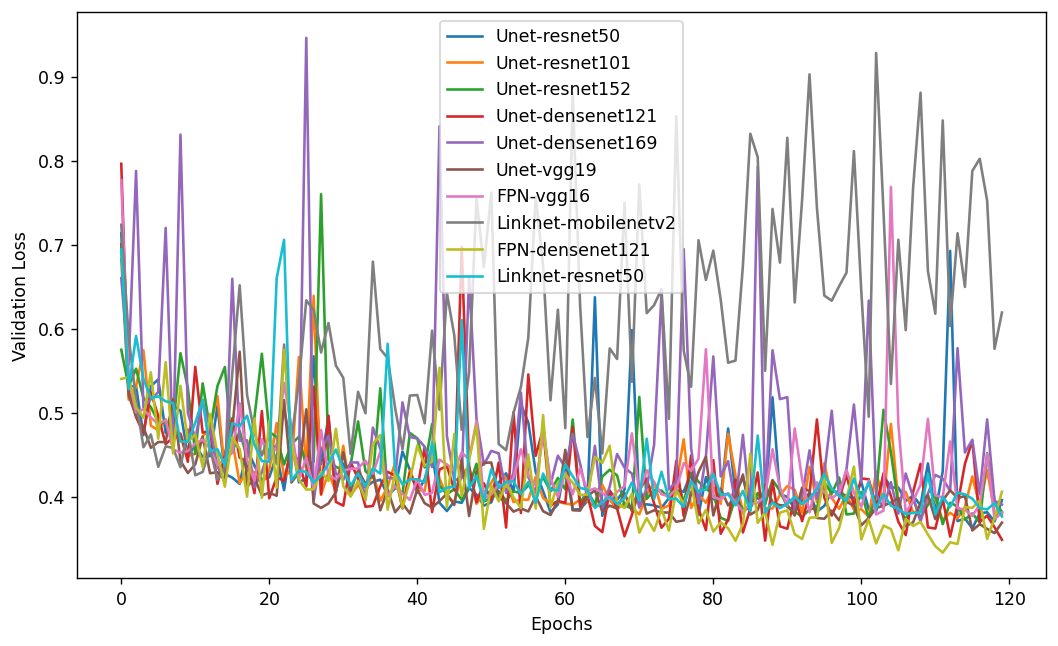

In [137]:
plt.figure(figsize = (10, 6), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Validation Loss');
plt.savefig(f'{path}/val_loss.jpg', format = 'jpg', dpi = 600)

### Validation IoU Comparison

In [138]:
mds_histories = []

for m in model_names:
    md = m.split('-')[0]
    bk = m.split('-')[1]

    file = open(f'{models_path}/{md}_{bk}/histroy_dict.txt', 'r')
    contents = file.read()

    dt = ast.literal_eval(contents)
    mds_histories.append(dt['val_iou'])

mds_hist_df = pd.DataFrame((mds_histories), index = model_names)
mds_hist_df = mds_hist_df.T

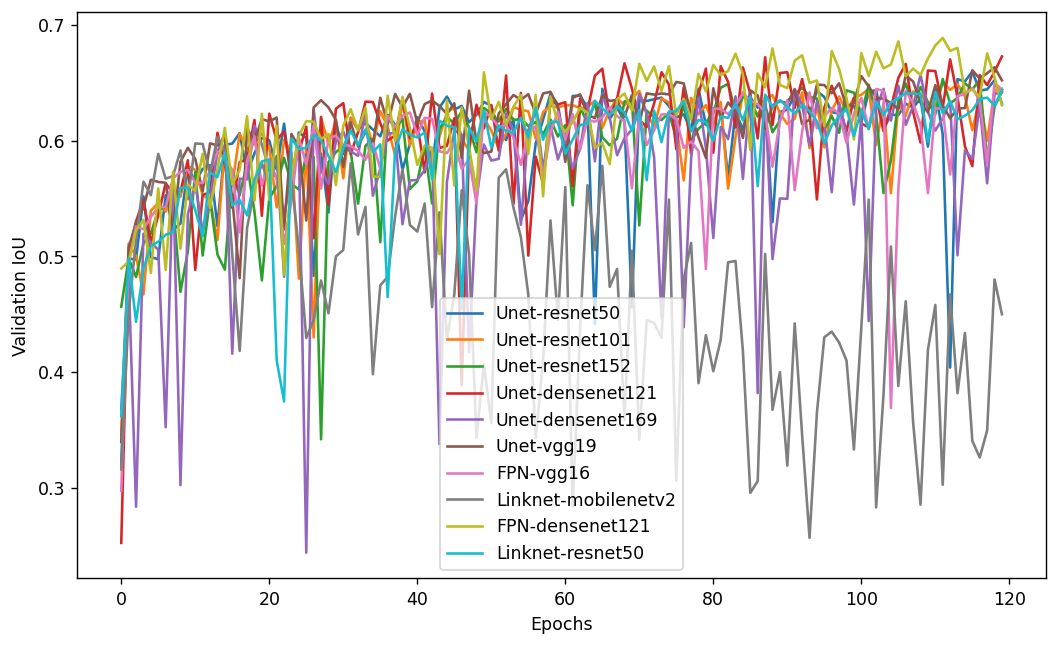

In [139]:
plt.figure(figsize = (10, 6), dpi = 125)
sns.lineplot(data = mds_hist_df, dashes = False);

plt.xlabel('Epochs');
plt.ylabel('Validation IoU');
plt.savefig(f'{path}/val_iou.jpg', format = 'jpg', dpi = 600)